# Detecting True and Deceptive Hotel Review

The Deceptive opinion spam dataset is a corpus consisting of truthful and deceptive hotel reviews of 20 Chicago hotels.

The corpus contains:

400 truthful, positive reviews from TripAdvisor
400 deceptive positive reviews from Mechanical Turk
400 truthful, negative reviews from Expedia, Hotels.com, Orbitz, Priceline, TripAdvisor, and Yelp
400 deceptive negative reviews from Mechanical Turk

In [ ]:
import os
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from textblob import TextBlob
from sklearn import svm
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from sklearn.grid_search import GridSearchCV
import regex as re
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
from sklearn.cross_validation import train_test_split
import fnmatch
from sklearn.svm import SVC,LinearSVC
from nltk import pos_tag,pos_tag_sents

Firstly, we extract the labels of the corpus into a CSV format.

In [34]:
path = "C:/Users/zoe_k/anaconda3/envs/zoe/op_spam_v1.4"

label=[]
config_files=[os.path.join(subdir,f)

for subdir,dirs,files in os.walk(path)
    for f in fnmatch.filter(files,"*.txt")]

In [35]:
for f in config_files:
    des=re.search("(trut|deceptiv)",f)
    label.append(des.group())

In [36]:
for f in config_files:
    des=re.search("(trut|deceptiv)",f)
    label.append(des.group())

In [37]:
corpus=pd.DataFrame(label,columns=["Labels"])

Then I extract the reviews in txt format into a list and after into a CSV format.

In [38]:
review=[]
for subdir,dirs,files in os.walk(path):
    for file in files:
        if fnmatch.filter(files,"*.txt"):
            f=open(os.path.join(subdir,file),'r')
            f=f.read()
            review.append(f)

In [39]:
reviews=pd.DataFrame(review,columns=["Review"])

Now,we merge the labels and the reviews into a single Dataset.

In [40]:
customer_review=pd.merge(reviews,corpus,right_index=True,left_index=True)
customer_review.Review=customer_review.Review.map(lambda x:x.lower())

In [41]:
customer_review.head()

Review    Labels
0  we stayed at the schicago hilton for 4 days an...  deceptiv
1  hotel is located 1/2 mile from the train stati...  deceptiv
2  i made my reservation at the hilton chicago be...  deceptiv
3  when most people think hilton, they think luxu...  deceptiv
4  my husband and i recently stayed stayed at the...  deceptiv

In [42]:
stop_words=stopwords.words("English")

In [43]:
customer_review['review_without_stopwords'] = customer_review['Review'].apply(lambda x: ' '.join([word for word in x.split() 
                                                                                                  if word not in (stop_words)]))

In [44]:
customer_review.head()

Review    Labels  \
0  we stayed at the schicago hilton for 4 days an...  deceptiv   
1  hotel is located 1/2 mile from the train stati...  deceptiv   
2  i made my reservation at the hilton chicago be...  deceptiv   
3  when most people think hilton, they think luxu...  deceptiv   
4  my husband and i recently stayed stayed at the...  deceptiv   

                            review_without_stopwords  
0  stayed schicago hilton 4 days 3 nights confere...  
1  hotel located 1/2 mile train station quite hik...  
2  made reservation hilton chicago believing goin...  
3  people think hilton, think luxury. know did. w...  
4  husband recently stayed stayed hilton chicago ...

POS TAGGING

In [45]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\zoe_k\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\zoe_k\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [46]:
def postagg(review):
    return TextBlob(review).tags
poss=customer_review.review_without_stopwords.apply(postagg)
poss=pd.DataFrame(poss)

In [47]:
poss["part_of_speech"] = poss['review_without_stopwords'].map(lambda x:" ".join(["/".join(x) for x in x ]) )

In [48]:
customer_review=pd.merge(customer_review,poss,right_index=True,left_index=True)

Splitting the Data into Trainning and Test Data & applying TF-IDF Vectorizer

In [49]:
train_review,test_review,train_label,test_label=train_test_split(customer_review.part_of_speech,
                                                                 customer_review.Labels,
                                                                 test_size=0.25,
                                                                random_state=10)
tf_vect=TfidfVectorizer(lowercase=True,use_idf=True,smooth_idf=True,sublinear_tf=False)
X_train=tf_vect.fit_transform(train_review)
X_test=tf_vect.transform(test_review)

Implementing the Model

In [50]:
def svc_param_selection(X, y, nfolds):
    Cs = [0.001, 0.01, 0.1, 1, 10]
    gammas = [0.001, 0.01, 0.1, 1]
    param_grid = {'C': Cs, 'gamma' : gammas}
    grid_search = GridSearchCV(svm.SVC(kernel='linear'), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    return grid_search.best_params_
svc_param_selection(X_train,train_label,6)

{'C': 1, 'gamma': 0.001}

In [51]:
clf=svm.SVC(C=1,gamma=0.001,kernel="linear")
clf.fit(X_train,train_label)
pred=clf.predict(X_test)

In [52]:
print(accuracy_score(pred,test_label))

0.8925


Plotting the confusion matrix, accuracy score and the classification report to analyse the performance of the model

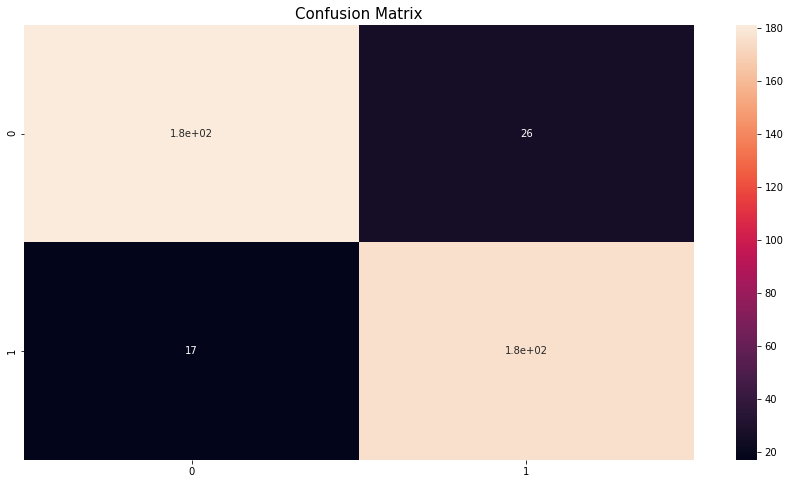

In [57]:
cm=confusion_matrix(pred,test_label)
f,ax=plt.subplots(figsize=(15,8))
sns.heatmap(cm,annot=True,ax=ax)
ax.set_title("Confusion Matrix",fontsize=15)
plt.show()

In [58]:
print(classification_report(pred,test_label))

              precision    recall  f1-score   support

    deceptiv       0.91      0.87      0.89       207
        trut       0.87      0.91      0.89       193

    accuracy                           0.89       400
   macro avg       0.89      0.89      0.89       400
weighted avg       0.89      0.89      0.89       400



In [59]:
with open("vectorizer.pickle",'wb') as model:
    pickle.dump(tf_vect,model)
with open("mlmodel.pickle",'wb') as m:
    pickle.dump(clf,m)